In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 

In [ ]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = HookedTransformer.from_pretrained(
    'google/gemma-7b',
    tokenizer=tokenizer,
    device='cuda',
    default_padding_side="right",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)

model.set_use_attn_result(True)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-7b into HookedTransformer


In [ ]:
import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
ap_graph.keys()

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

In [ ]:
from transformer_lens import HookedTransformer, utils
with torch.no_grad():
    _logits, cache = model.run_with_cache("Why did the chicken cross the")
    print(cache.keys())

print(utils.get_act_name("k", layer=4))
# print(cache[utils.get_act_name("k", layer=4)])
print(cache['blocks.0.mlp.hook_post'].shape)
print(cache['blocks.0.attn.hook_q'].shape)

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln

In [ ]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 16
eval_batch_size=64

device = "cuda"
train_loss_type = "sports"
forget_sport = "basketball"
maintain_sport = None
# val_sport = "baseball"


sports_1mp = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="log_1_minus_p", forget_sport_subset={forget_sport}, is_forget_dataset=True)

if maintain_sport is None:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
else:
    maintain_sports = SportsTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=256, shuffle=True, buffer_size=50000)
train_tasks = {"sports_1mp": (sports_1mp, .2), "maintain_sports": (maintain_sports, 1), "pile": (train_pile, 1)}

# want to eval on other sports
forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=True)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={forget_sport}, is_forget_dataset=False)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}
else:
    maintain_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={maintain_sport}, is_forget_dataset=True)
    val_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", forget_sport_subset={val_sport}, is_forget_dataset=True)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": 
                  forget_sport_eval, "maintain_sport": maintain_sport_eval, "val_sport": val_sport_eval}

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


### Test passing gradients through localized mask

In [6]:
from circuit_breaking.src.masks import NeuronLevelMask

# components = ['blocks.0.attn.hook_k', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_v', 
#               'blocks.0.attn.hook_result', 
#               'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 
#             #   'blocks.0.hook_q_input', 'blocks.0.hook_k_input', 'blocks.0.hook_v_input', 
#             #   'blocks.0.hook_mlp_in', 
#               'blocks.0.hook_attn_out', 
#               'blocks.0.hook_mlp_out', 
#               'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', ]
components = ["blocks.1.attn.hook_q", "blocks.2.attn.hook_result", "blocks.3.attn.hook_k", "blocks.4.attn.hook_v", "blocks.3.mlp.hook_pre", "blocks.10.mlp.hook_post", "blocks.10.mlp.hook_pre"]
component_heads = {"blocks.1.attn.hook_q": [3], "blocks.2.attn.hook_result": list(range(model.cfg.n_heads)), "blocks.3.attn.hook_k": [4, 10], "blocks.4.attn.hook_v": [4, 10]}

for component in components:
    print(f"Component: {component}, shape {cache[component].shape}")

localized_mask = NeuronLevelMask(model, components=components, component_heads=component_heads)

Component: blocks.1.attn.hook_q, shape torch.Size([1, 7, 16, 256])
Component: blocks.2.attn.hook_result, shape torch.Size([1, 7, 16, 3072])
Component: blocks.3.attn.hook_k, shape torch.Size([1, 7, 16, 256])
Component: blocks.4.attn.hook_v, shape torch.Size([1, 7, 16, 256])
Component: blocks.3.mlp.hook_pre, shape torch.Size([1, 7, 24576])
Component: blocks.10.mlp.hook_post, shape torch.Size([1, 7, 24576])
Component: blocks.10.mlp.hook_pre, shape torch.Size([1, 7, 24576])


In [7]:
for name, param in localized_mask.named_parameters():
    print(f"Param {name}, shape {param.shape}, {param.requires_grad=}")

Param masks.blocks&1&attn&hook_q, shape torch.Size([16, 256]), param.requires_grad=True
Param masks.blocks&2&attn&hook_result, shape torch.Size([16, 3072]), param.requires_grad=True
Param masks.blocks&3&attn&hook_k, shape torch.Size([16, 256]), param.requires_grad=True
Param masks.blocks&4&attn&hook_v, shape torch.Size([16, 256]), param.requires_grad=True
Param masks.blocks&3&mlp&hook_pre, shape torch.Size([24576]), param.requires_grad=True
Param masks.blocks&10&mlp&hook_post, shape torch.Size([24576]), param.requires_grad=True
Param masks.blocks&10&mlp&hook_pre, shape torch.Size([24576]), param.requires_grad=True
Param attn_mask_frozen.blocks&1&attn&hook_q, shape torch.Size([16, 1]), param.requires_grad=False
Param attn_mask_frozen.blocks&2&attn&hook_result, shape torch.Size([16, 1]), param.requires_grad=False
Param attn_mask_frozen.blocks&3&attn&hook_k, shape torch.Size([16, 1]), param.requires_grad=False
Param attn_mask_frozen.blocks&4&attn&hook_v, shape torch.Size([16, 1]), param.r

In [8]:
pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=256, shuffle=True, buffer_size=1000)
# localized_mask.cpu()
print(torch.cuda.memory_allocated())
localized_mask.cuda()
print(torch.cuda.memory_allocated())
loss = pile.get_train_loss(model)
print(torch.cuda.memory_allocated())
loss.backward()
print(torch.cuda.memory_allocated())
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Param {name}, shape {param.shape}, {param.requires_grad=}")

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.


In [11]:
# component_heads = {"blocks.1.attn.hook_q": [3], "blocks.2.attn.hook_result": list(range(model.cfg.n_heads)), "blocks.3.attn.hook_k": [4, 10], "blocks.4.attn.hook_v": [4, 10]}
print(localized_mask.attn_masks[localized_mask.convert_param_name("blocks.1.attn.hook_q")].grad[[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]].norm())
print(localized_mask.attn_masks[localized_mask.convert_param_name("blocks.1.attn.hook_q")].grad[3].norm())

print((localized_mask.attn_masks[localized_mask.convert_param_name("blocks.2.attn.hook_result")].grad != 0).float().mean())

# Assuming localized_mask is already defined and contains the necessary gradients
grad_tensor = localized_mask.attn_masks[localized_mask.convert_param_name("blocks.2.attn.hook_result")].grad
zero_grad_indices = torch.nonzero(grad_tensor == 0, as_tuple=False)
# print(zero_grad_indices)

print(localized_mask.attn_masks[localized_mask.convert_param_name("blocks.3.attn.hook_k")].grad.norm(dim=1))

print(localized_mask.attn_mask_frozen[localized_mask.convert_param_name("blocks.3.attn.hook_k")].grad)
print(localized_mask.attn_mask_unfrozen[localized_mask.convert_param_name("blocks.3.attn.hook_k")].grad)

AttributeError: 'NeuronLevelMask' object has no attribute 'attn_masks'

In [ ]:
# components = ["blocks.1.attn.hook_q", "blocks.2.attn.hook_result", "blocks.3.attn.hook_k", "blocks.4.attn.hook_v", "blocks.3.mlp.hook_pre", "blocks.10.mlp.hook_post", "blocks.10.mlp.hook_pre"]
print((localized_mask.masks[localized_mask.convert_param_name("blocks.10.mlp.hook_post")].grad == 0).float().mean())
print(localized_mask.masks[localized_mask.convert_param_name("blocks.10.mlp.hook_pre")].grad)
print(localized_mask.masks[localized_mask.convert_param_name("blocks.3.mlp.hook_pre")].grad)

tensor(0.0002, device='cuda:0')
tensor([ 2.9802e-05,  1.1832e-05,  5.0366e-06,  ...,  6.0499e-06,
        -1.6809e-05,  7.3969e-05], device='cuda:0')
tensor([-8.6546e-05,  5.7429e-05, -5.3644e-07,  ...,  1.1921e-07,
         1.7315e-05,  1.1802e-05], device='cuda:0')


### Train Masks

In [ ]:
def convert_attrs_to_components(attrs, combine_heads=False, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads):
    """
    attrs is dictionary of e.g. {'a0.0_q': float, 'm27_in': float}

    If combine_heads, then it will combine all 'a0.0_q', 'a0.1_q', ..., 'a0.15_q', etc into one component.
    """

    component_dict = defaultdict(int)
    attn_head_dict = defaultdict(dict)
    for layer in range(n_layers):
        for attn_type, component_name in [("q", f"blocks.{layer}.attn.hook_q"), ("k", f"blocks.{layer}.attn.hook_k"), ("v", f"blocks.{layer}.attn.hook_v"), ("result", f"blocks.{layer}.attn.hook_result")]:
            for head in range(n_heads):    
                if combine_heads:
                    component_dict[component_name] += attrs[f"a{layer}.{head}_{attn_type}"]
                else:
                    attn_head_dict[component_name][head] = attrs[f"a{layer}.{head}_{attn_type}"]
        for mlp_type, component_name in [("in", f"blocks.{layer}.mlp.hook_pre"), ("out", f"blocks.{layer}.mlp.hook_post")]:
            component_dict[component_name] += attrs[f"m{layer}_{mlp_type}"]
    if combine_heads:
        return (component_dict,)
    return (component_dict, attn_head_dict,)


def get_top_components(component_dict, attn_head_dict=None, threshold=None, top_p=None, top_k=None, use_abs=True, n_layers=model.cfg.n_layers, n_heads=model.cfg.n_heads):
    """
    component_dict is a dictionary of components to their importance values. If attn_head_dict is not None, then component_dict and attn_head_dict should not overlap in values.

    Can either use a threshold, top_p, or top_k to determine the top components to return (can only specify one). top_p should be a value ranging from 0 to 100. If use_abs is True, then it will take the absolute value of the importance values. 
    """
    if attn_head_dict is not None:
        assert (component_dict.keys() & attn_head_dict.keys()) == set(), "Overlapping keys between component_dict and attn_head_dict"
    
    # assert only one of threshold, top_p, top_k is specified
    assert sum([threshold is not None, top_p is not None, top_k is not None]) == 1, "Can only specify one of threshold, top_p, top_k"
    # will calculate a threshold for top_p or top_k

    if top_p is not None:
        all_attr_values = list(component_dict.values())
        if attn_head_dict is not None:
            all_attr_values += [val for head_dict in attn_head_dict.values() for val in head_dict.values()]

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        print(f"{len(all_attr_values)=}")
        threshold = np.percentile(all_attr_values, 100 - top_p)
    elif top_k is not None:
        all_attr_values = list(component_dict.values())
        if attn_head_dict is not None:
            all_attr_values += [val for head_dict in attn_head_dict.values() for val in head_dict.values()]

        all_attr_values = np.array(all_attr_values)
        if use_abs:
            all_attr_values = np.abs(all_attr_values)
        threshold = np.sort(all_attr_values)[-top_k]
    
    print(f"Thresholding importance at {threshold}")
    final_components = []
    final_attn_heads = defaultdict(list)

    for component, importance in component_dict.items():
        if use_abs:
            importance = abs(importance)
        if importance >= threshold:
            final_components.append(component)    

    if attn_head_dict is not None:
        for component, head_dict in attn_head_dict.items():
            head_list = []
            for head, importance in head_dict.items():
                if use_abs:
                    importance = abs(importance)
                if importance >= threshold:
                    head_list.append(head)
            if len(head_list) > 0:
                final_attn_heads[component] = head_list
                final_components.append(component)
    else:
        for component in final_components:
            if "attn" in component:
                # want to mask over all possible heads
                final_attn_heads[component] = list(range(n_heads))
    
    return final_components, final_attn_heads
print(get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=True), top_p=5))
print(get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=False), top_k=20))


len(all_attr_values)=168
Thresholding importance at 0.20463522672653203
(['blocks.18.attn.hook_result', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.23.mlp.hook_post', 'blocks.25.attn.hook_result', 'blocks.25.mlp.hook_pre', 'blocks.27.attn.hook_q', 'blocks.27.attn.hook_k', 'blocks.27.mlp.hook_post'], defaultdict(<class 'list'>, {'blocks.18.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.25.attn.hook_result': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.27.attn.hook_q': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'blocks.27.attn.hook_k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}))
Thresholding importance at 0.11414513221153846
(['blocks.0.mlp.hook_pre', 'blocks.13.mlp.hook_pre', 'blocks.19.mlp.hook_pre', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_pre', 'blocks.23.mlp.hook_post', 'blocks.25.mlp.hook_pre', 'bloc

In [ ]:
use_localized_mask = True

combine_heads = False
top_p = 5

if use_localized_mask:
    final_components, final_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=top_p)

    print(final_components)
    print(final_attn_heads)

    mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)

else:
    all_components, all_attn_heads = get_top_components(*convert_attrs_to_components(ap_graph, combine_heads=combine_heads), top_p=100)
    print(len(all_components))
    print(len(all_attn_heads))
    assert (torch.tensor([len(x) for x in all_attn_heads.values()]) == model.cfg.n_heads).all()

    mask = NeuronLevelMask(model, components=all_components, component_heads=all_attn_heads)


len(all_attr_values)=1848
Thresholding importance at 0.0332934452937199
['blocks.0.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.2.mlp.hook_post', 'blocks.4.mlp.hook_pre', 'blocks.5.mlp.hook_pre', 'blocks.10.mlp.hook_pre', 'blocks.11.mlp.hook_post', 'blocks.12.mlp.hook_pre', 'blocks.12.mlp.hook_post', 'blocks.13.mlp.hook_pre', 'blocks.13.mlp.hook_post', 'blocks.14.mlp.hook_pre', 'blocks.14.mlp.hook_post', 'blocks.15.mlp.hook_pre', 'blocks.15.mlp.hook_post', 'blocks.16.mlp.hook_pre', 'blocks.17.mlp.hook_post', 'blocks.18.mlp.hook_pre', 'blocks.18.mlp.hook_post', 'blocks.19.mlp.hook_pre', 'blocks.20.mlp.hook_pre', 'blocks.20.mlp.hook_post', 'blocks.21.mlp.hook_pre', 'blocks.21.mlp.hook_post', 'blocks.22.mlp.hook_pre', 'blocks.22.mlp.hook_post', 'blocks.23.mlp.hook_pre', 'blocks.23.mlp.hook_post', 'blocks.24.mlp.hook_pre', 'blocks.24.mlp.hook_post', 'blocks.25.mlp.hook_pre', 'blocks.25.mlp.hook_post', 'blocks.26.mlp.hook_pre', 'blocks.26.mlp.hook_post', 'blocks.27.mlp.hook_pre', 'block

In [ ]:
# print(torch.cuda.memory_allocated())
# reg_loss = localized_mask.regularization_loss()
# print(reg_loss)
# print(torch.cuda.memory_allocated())
# reg_loss.backward()
# print(torch.cuda.memory_allocated())
# print(localized_mask.masks[localized_mask.convert_param_name('blocks.1.mlp.hook_post')].grad.norm())
# print(localized_mask.attn_masks[localized_mask.convert_param_name('blocks.16.attn.hook_result')].grad.norm(dim=1))

# print(localized_mask.attn_mask_unfrozen[localized_mask.convert_param_name('blocks.16.attn.hook_result')].grad)
# print(localized_mask.attn_mask_frozen[localized_mask.convert_param_name('blocks.16.attn.hook_result')].grad)

In [ ]:
# mask = MLPHiddenMask(model).cuda()

learning_rate = 5e-2
n_epochs = 100
grad_accum_steps = 4
# max_gpu_batch_size=8
beta = 10
clip_grad = 1

evaluate_every = 5
n_eval_iters = 5
deep_evaluate_every = 10
do_adversarial_evals = True
do_side_effects_evals = False

from collections import defaultdict
all_train_losses = defaultdict(list)
all_test_losses = defaultdict(list)
adversarial_evals = []
side_effect_evals = []
mask.cuda()

# Initialize optimizer

optimizer = torch.optim.AdamW(mask.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
# Cycle dataloaders
# Train a sparse mask
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    # Sample batches
    # Reset grad
    optimizer.zero_grad()
    # Compute normal loss over retain
    for task_name, (task, task_weight) in train_tasks.items():
        task_loss = 0
        for i in range(grad_accum_steps):
            loss = task.get_train_loss(model) / grad_accum_steps
            task_loss += loss.item()
            loss *= task_weight
            loss.backward()
        all_train_losses[task_name].append(task_loss)
        
    # Add sparsity loss and backprop
    loss = beta * mask.regularization_loss()
    loss.backward()
    all_train_losses["reg"].append(loss.item())
    # Step and log
    if clip_grad is not None:
        torch.nn.utils.clip_grad_norm_(mask.parameters(), clip_grad)
    # zero_nan_grads(mask)
    optimizer.step()
    mask.on_step_end()
    scheduler.step()

    if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
        for task_name, task in eval_tasks.items():
            task_loss = 0
            for i in range(n_eval_iters):
                task_loss += task.get_test_loss(model).item()
            all_test_losses[task_name].append(task_loss / n_eval_iters)
    if epoch % deep_evaluate_every == 0 or epoch == n_epochs - 1:
        if do_adversarial_evals:
            print("Running adversarial evals")
            adversarial_evals.append(adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True))
        if do_side_effects_evals:
            print("Running side effects evals")
            side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers"]))
    

  0%|          | 0/10 [00:00<?, ?it/s]

Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Running adversarial evals


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# save masks state dict to neuron_cb
torch.save(mask.state_dict(), f"masks/neuron_cb/{model_type}_{'localized' if use_localized_mask else 'nonlocalized'}_{combine_heads=}_unlearn_{forget_sport}.pt")

## Analyze Mask

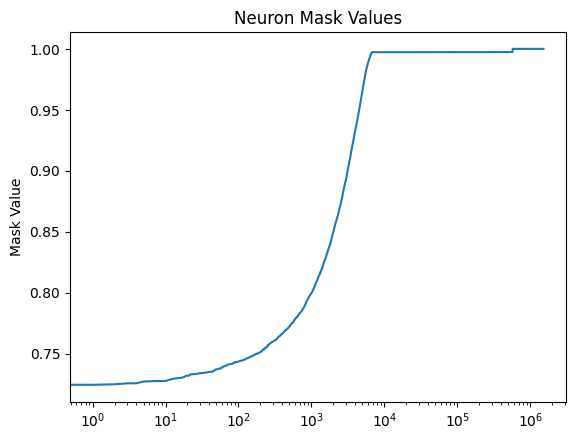

In [11]:
# Visualize the neuron coefficients
all_values = torch.cat([m.data.flatten() for m in mask.masks.values()], dim=0).cpu()
sorted = all_values.sort().values
plt.semilogx(sorted)
plt.title("Neuron Mask Values")
plt.ylabel("Mask Value")
plt.show()

In [14]:
mask.mask_masks.keys()

dict_keys(['blocks&0&mlp&hook_pre', 'blocks&1&mlp&hook_post', 'blocks&2&mlp&hook_post', 'blocks&4&mlp&hook_pre', 'blocks&5&mlp&hook_pre', 'blocks&10&mlp&hook_pre', 'blocks&11&mlp&hook_post', 'blocks&12&mlp&hook_pre', 'blocks&12&mlp&hook_post', 'blocks&13&mlp&hook_pre', 'blocks&13&mlp&hook_post', 'blocks&14&mlp&hook_pre', 'blocks&14&mlp&hook_post', 'blocks&15&mlp&hook_pre', 'blocks&15&mlp&hook_post', 'blocks&16&mlp&hook_pre', 'blocks&17&mlp&hook_post', 'blocks&18&mlp&hook_pre', 'blocks&18&mlp&hook_post', 'blocks&19&mlp&hook_pre', 'blocks&20&mlp&hook_pre', 'blocks&20&mlp&hook_post', 'blocks&21&mlp&hook_pre', 'blocks&21&mlp&hook_post', 'blocks&22&mlp&hook_pre', 'blocks&22&mlp&hook_post', 'blocks&23&mlp&hook_pre', 'blocks&23&mlp&hook_post', 'blocks&24&mlp&hook_pre', 'blocks&24&mlp&hook_post', 'blocks&25&mlp&hook_pre', 'blocks&25&mlp&hook_post', 'blocks&26&mlp&hook_pre', 'blocks&26&mlp&hook_post', 'blocks&27&mlp&hook_pre', 'blocks&27&mlp&hook_post', 'blocks&14&attn&hook_q', 'blocks&14&attn&

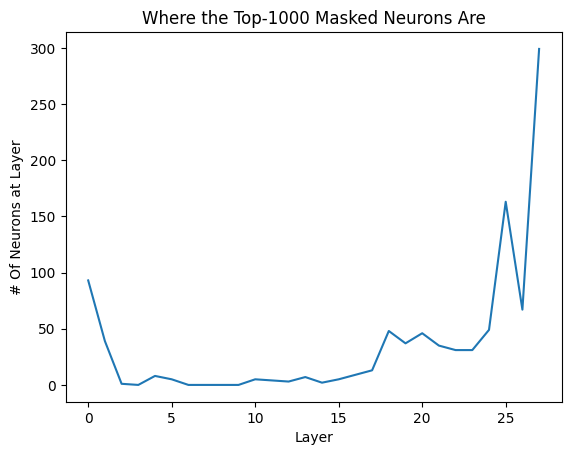

In [17]:
# Visualize the neuron coefficients
mask.undiscretize()
mask.discretize_topk(1000)
all_values = {layer: 0 for layer in range(model.cfg.n_layers)}
for component in mask.mask_masks:
    layer = int(component.split("&")[1])
    all_values[layer] += (mask.mask_masks[component].data == 1).sum().item()

# all_values = [(m.data == 1).sum().item() for m in mask.mask_masks.values()]
plt.plot(all_values.values())
plt.title("Where the Top-1000 Masked Neurons Are")
plt.ylabel("# Of Neurons at Layer")
plt.xlabel("Layer")
plt.show()

In [9]:
# Final evals
final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=True)
print(f"System Prompt: adversarial evals are {final_adversarial_eval}")
final_adversarial_eval = adversarial_sports_eval(model, model_type=model_type, batch_size=eval_batch_size, use_system_prompt=False)
print(f"No System Prompt: adversarial evals are {final_adversarial_eval}")

final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Sports Familiarity", "Cross Entropy"], verbose=True)
print(final_side_effects)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


System Prompt: adversarial evals are {'Normal': {'football': 0.996875, 'baseball': 1.0, 'basketball': 0.80390625}, 'MC': {'football': 0.98046875, 'baseball': 0.94921875, 'basketball': 0.865625}, 'Capitalized': {'football': 0.99296875, 'baseball': 1.0, 'basketball': 0.81328125}, 'Dashed': {'football': 0.659896194934845, 'baseball': 0.9808665990829468, 'basketball': 0.9124550938606263}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


No System Prompt: adversarial evals are {'Normal': {'football': 0.99609375, 'baseball': 0.98515625, 'basketball': 0.08134765625000001}, 'MC': {'football': 0.95078125, 'baseball': 0.8578125000000001, 'basketball': 0.7671875}, 'Capitalized': {'football': 0.9984375000000001, 'baseball': 0.97265625, 'basketball': 0.10683593749999999}, 'Dashed': {'football': 0.9331541180610657, 'baseball': 0.9926276803016663, 'basketball': 0.8452224969863892}}


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Sports Answers:
football: 50/50
baseball: 50/50
basketball: 49/50
tennis: 49/50
Processing questions 0 to 64 of 200
Falling back to custom generation due to exception: HookedTransformer.generate() got an unexpected keyword argument 'input_ids'
Running model as a model inference function instead of a huggingface model.
Processing questions 64 to 128 of 200
Falling back to custom generation due to exception: HookedTransformer.generate() got an unexpected keyword argument 'input_ids'
Running model as a model inference function instead of a huggingface model.
Processing questions 128 to 192 of 200
Falling back to custom generation due to exception: HookedTransformer.generate() got an unexpected keyword argument 'input_ids'
Running model as a model inference function instead of a huggingface model.
Processing questions 192 to 256 of 200
Falling back to custom generation due to exception: HookedTransformer.generate() got an unexpected keyword argument 'input_ids'
Running model as a model inf

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Unlearned Model Familiarity: defaultdict(<class 'int'>, {'baseball': 0.02})
Moving model to device:  cuda


0it [00:00, ?it/s]

generating model responses...


TypeError: HookedTransformer.generate() got an unexpected keyword argument 'input_ids'